Compare trained model weights with and without noise matrix.

Compare and visualize all weights in both models.

- trained at 2 different $f_p$: [0.1, 0.9]

Things to viz / quantify:

- performances across feature_probs
- onehot input-output heatmap (in=1, in=-1)
- input-output response curves
- condition number of effective targets
- singular value spectra of effective targets

In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from scipy.stats import describe, kstest, mannwhitneyu, sem
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis import plot, util

In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 14})

In [3]:
"""Set torch device."""

# device = t.device("cpu")  # small toy models may be faster via cpu
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [4]:
sns.set_style("whitegrid")

plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 13

In [5]:
np.exp(- (1/2 * np.log(1/2)) * 2)

np.float64(2.0)

## Training the models

In [6]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device,
    target: str = "relu+x"
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    if target == "relu+x":
        return x, t.relu(x) + x
    elif target == "relu":
        return x, t.relu(x)
    else:
        raise ValueError(f"Unknown target: {target}")

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device,
    target: str = "relu+x"
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device, target)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device,
    target: str = "relu+x",
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device, target)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

In [86]:
"""Set up and train models."""

feat_sparsity = 0.9
feat_prob = 1 - feat_sparsity
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 1024
n_steps = 10000
logging_freq = n_steps // 10
n_feat=2
n_hidden=1

# target_integral = 5/3  # 5/3 is integral of (relu(x) + x)**2 from -1 to 1
target_integral = 1/3  # 1/3 is integral of (relu(x))**2 from -1 to 1
interval_length = 2
naive_loss = target_integral / interval_length * ((n_feat - n_hidden) / n_feat) * feat_prob
print(f"naive loss: {naive_loss:.2e}")

naive loss: 8.33e-03


### no residual

In [87]:
cis_simple_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)
cis_simple = Cis(cis_simple_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
    target="relu",
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [88]:
eval_losses = eval_model(
    cis_simple, 
    batch_sz=10000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device,
    target="relu",
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 8.23e-03


### residual w/noise

In [143]:
noise_params = {
     "matrix_type": "symmetric",
     "noise_coeff": 0.2,
     "learned": True,
}

#noise_params = {
#    "matrix_type": "rank-r",
#    "r": 1,
#    "noise_coeff": 0.2,
#    "learned": False,
#}

cis_simple_sym_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)

feat_sparsity = 0.9

cis_simple_sym = Cis(cis_simple_sym_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple_sym.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple_sym,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [144]:
eval_losses = eval_model(
    cis_simple_sym, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 5.42e-03


In [145]:
print(cis_simple_sym.noise_coeff)
print(cis_simple_sym.noise_base)

Parameter containing:
tensor(-0.4034, device='cuda:0', requires_grad=True)
tensor([[[0.0000, 0.8293],
         [0.8293, 0.0000]]], device='cuda:0')


## Model Viz

In [139]:
models = [cis_simple, cis_simple_sym]
model_names = ["relu", "relu+x_sym"]
targets = ["relu", "relu+x"]

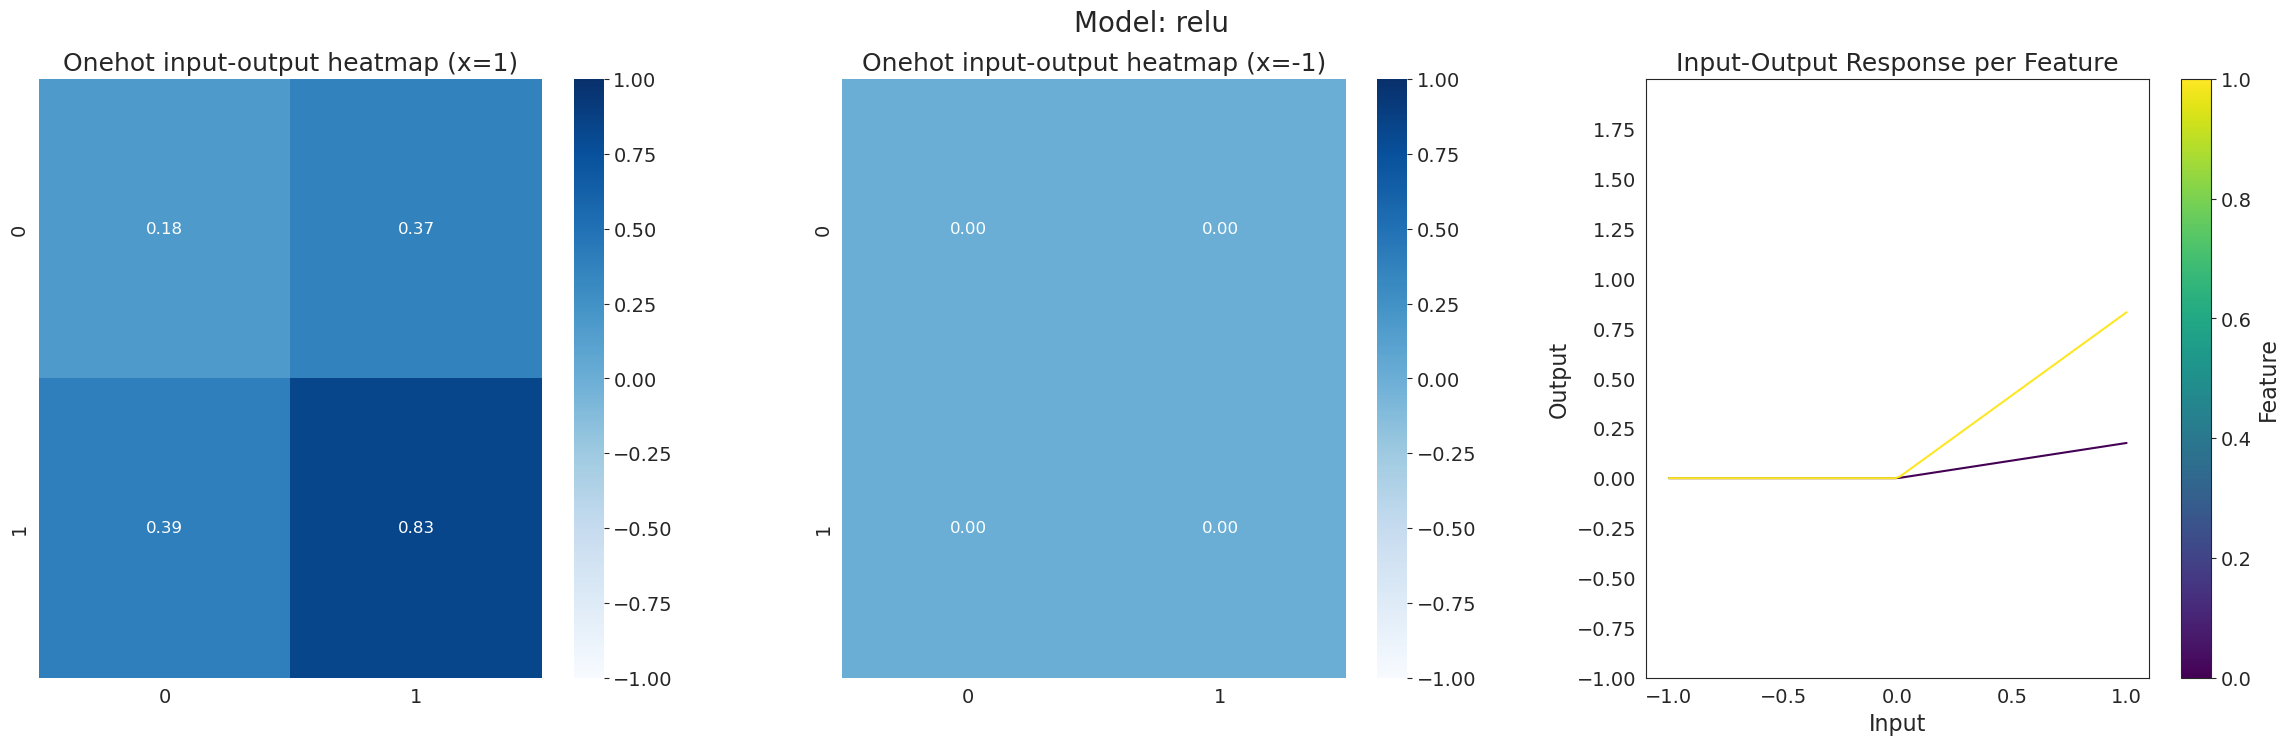

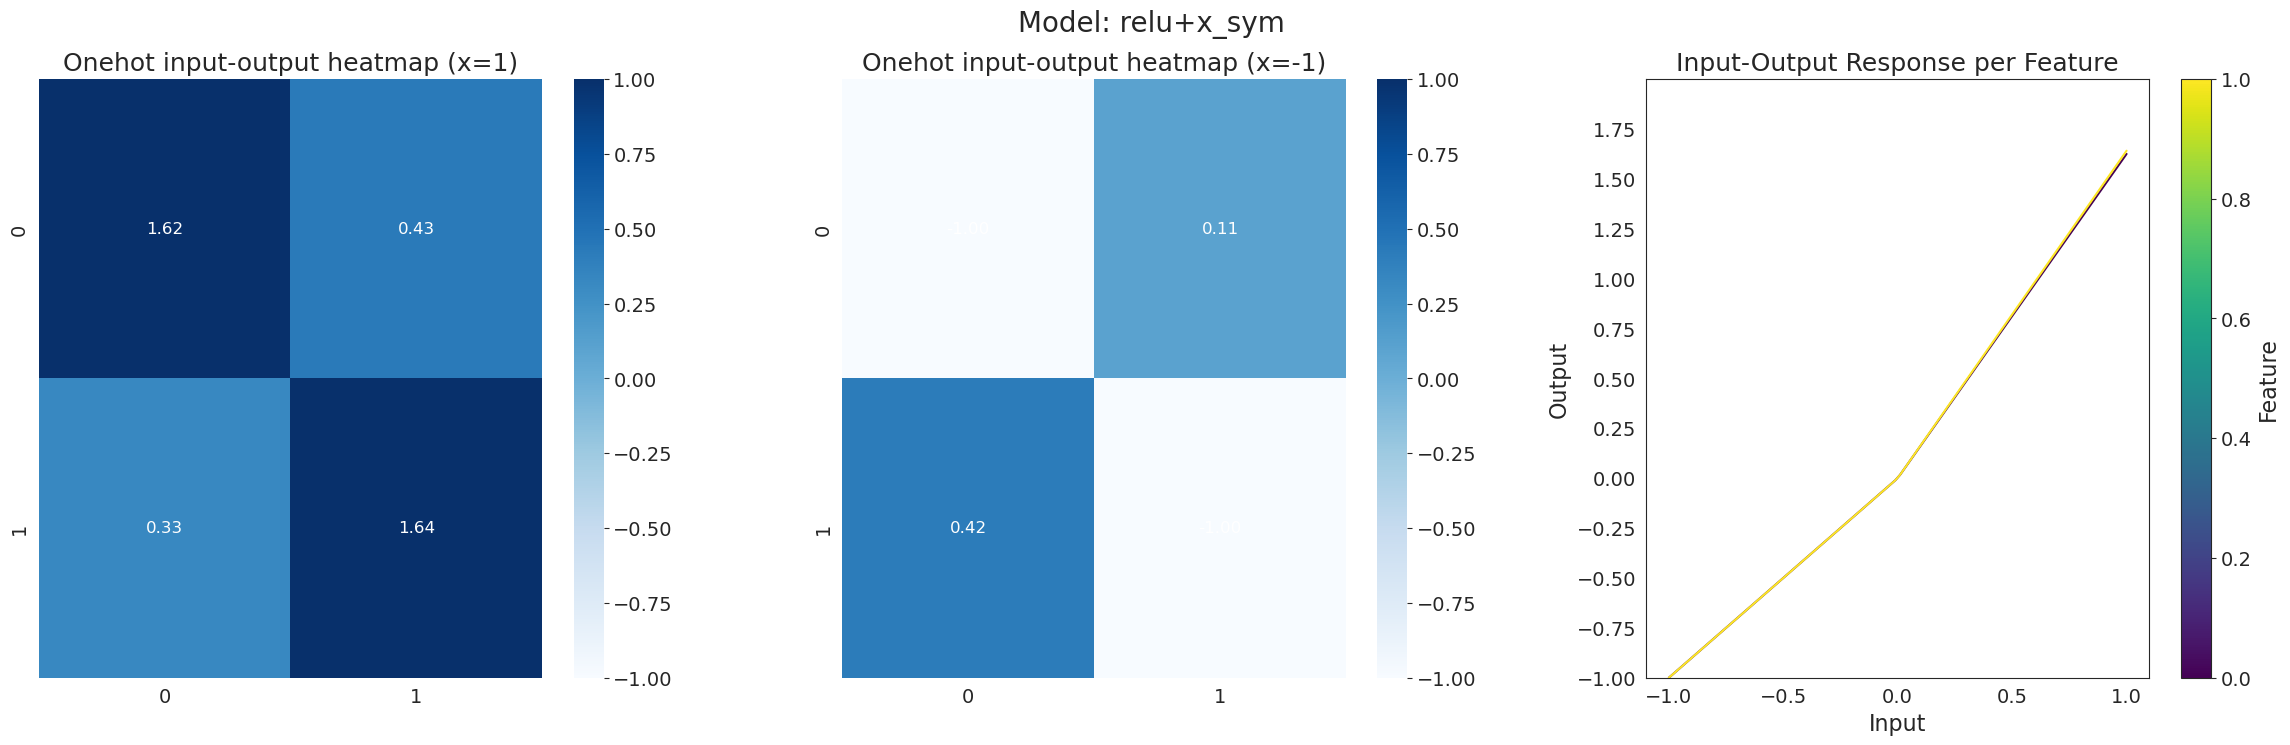

In [146]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    
    plot.plot_input_output_heatmap(1, model, ax=axs[0], annot=True, cmap="Blues")
    plot.plot_input_output_heatmap(-1, model, ax=axs[1], annot=True, cmap="Blues")
    x = t.linspace(-1, 1, 100, device=device)
    Y = util.in_out_response(model, x, device=device)
    plot.plot_input_output_response(Y, x, list(range(model.cfg.n_feat)), ax=axs[2])
    axs[2].set_ylim(-1, 2)
    axs[2].set_yticks(np.arange(-1, 2, 0.25))

    
    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

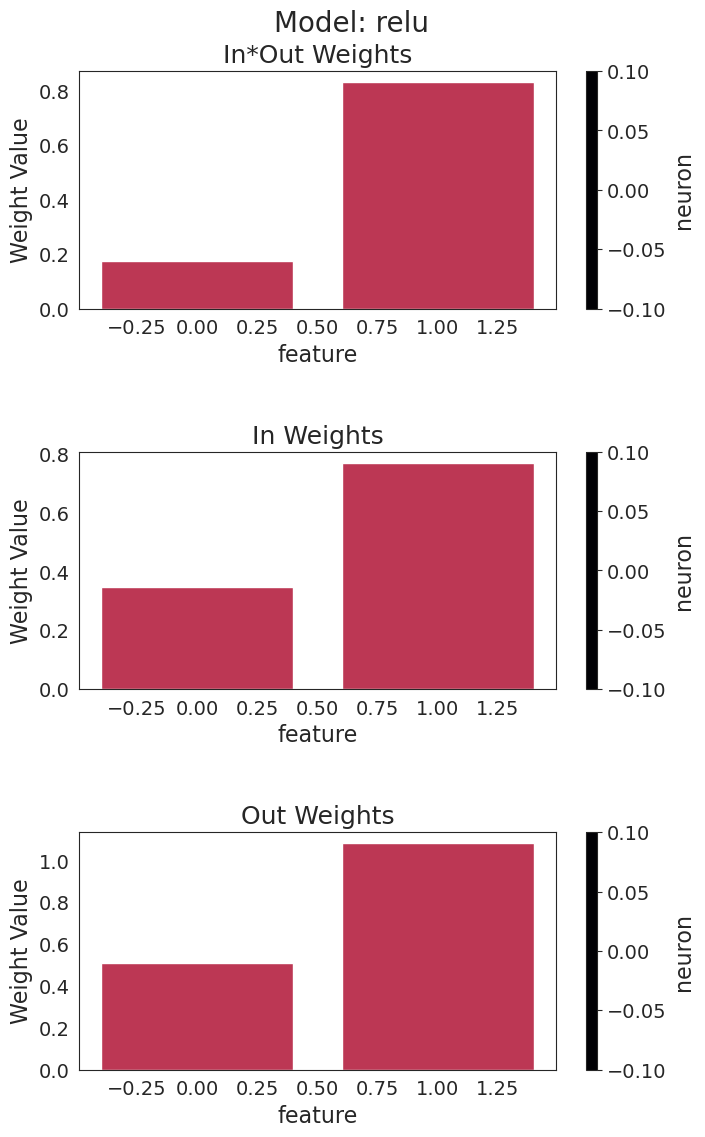

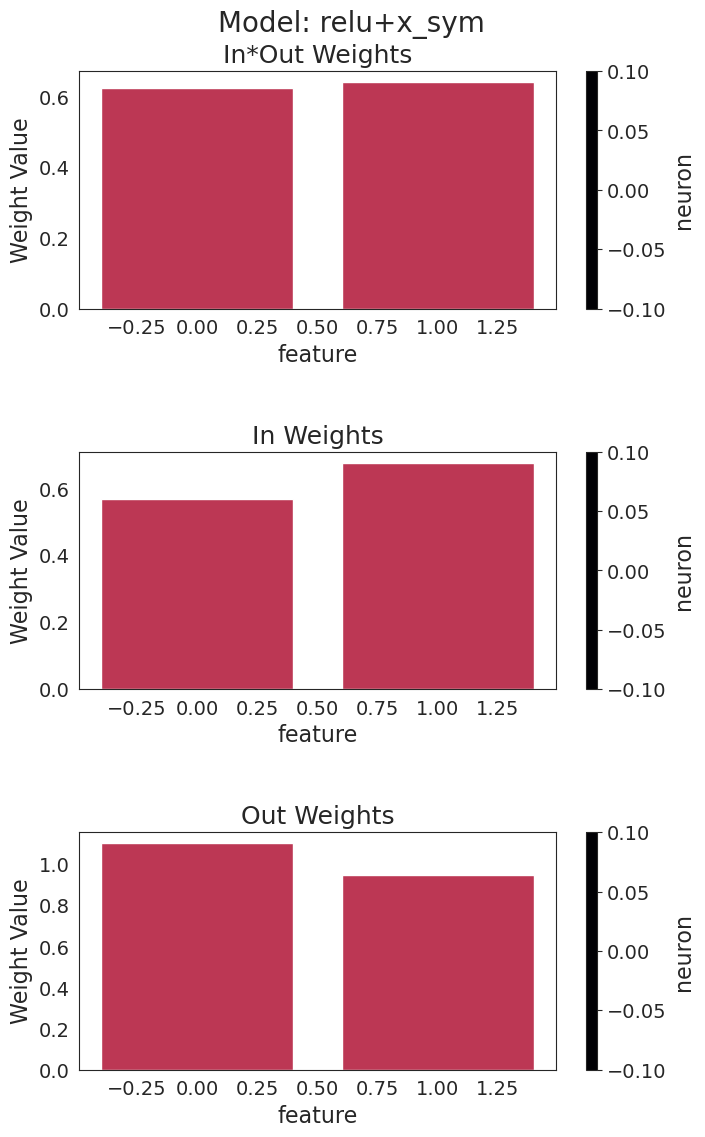

In [147]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    W_adj = einsum(model.W1, model.W2, "inst dmlp feat, inst feat dmlp -> dmlp feat")
    W_adj = util.threshold_matrix(W_adj, threshold=0.001)
    plot.plot_weight_bars(W_adj, xax="feature", ax=axs[0])
    axs[0].set_title("In*Out Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W1[0], threshold=0.001), xax="feature", ax=axs[1]
    )
    axs[1].set_title("In Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W2[0].T, threshold=0.001), xax="feature", ax=axs[2]
    )
    axs[2].set_title("Out Weights")

    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

### p=0.1

#### Performance across feature_probs

Testing across feature sparsities: 100%|██████████| 19/19 [00:00<00:00, 22.85it/s]


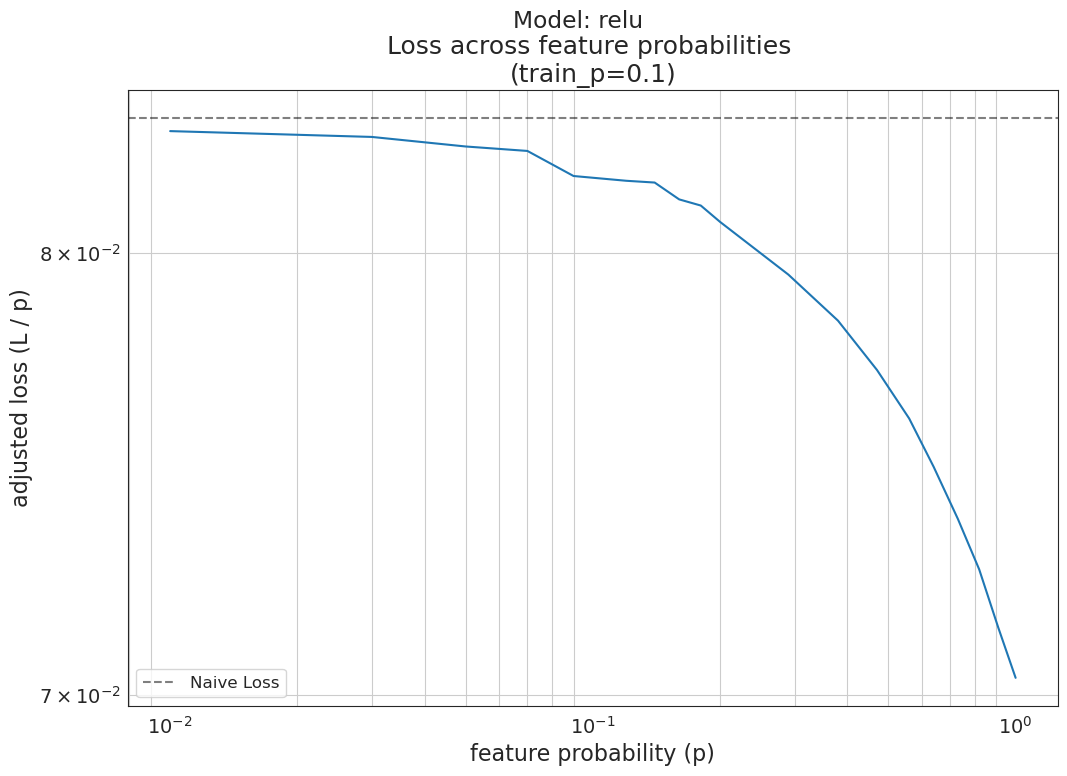

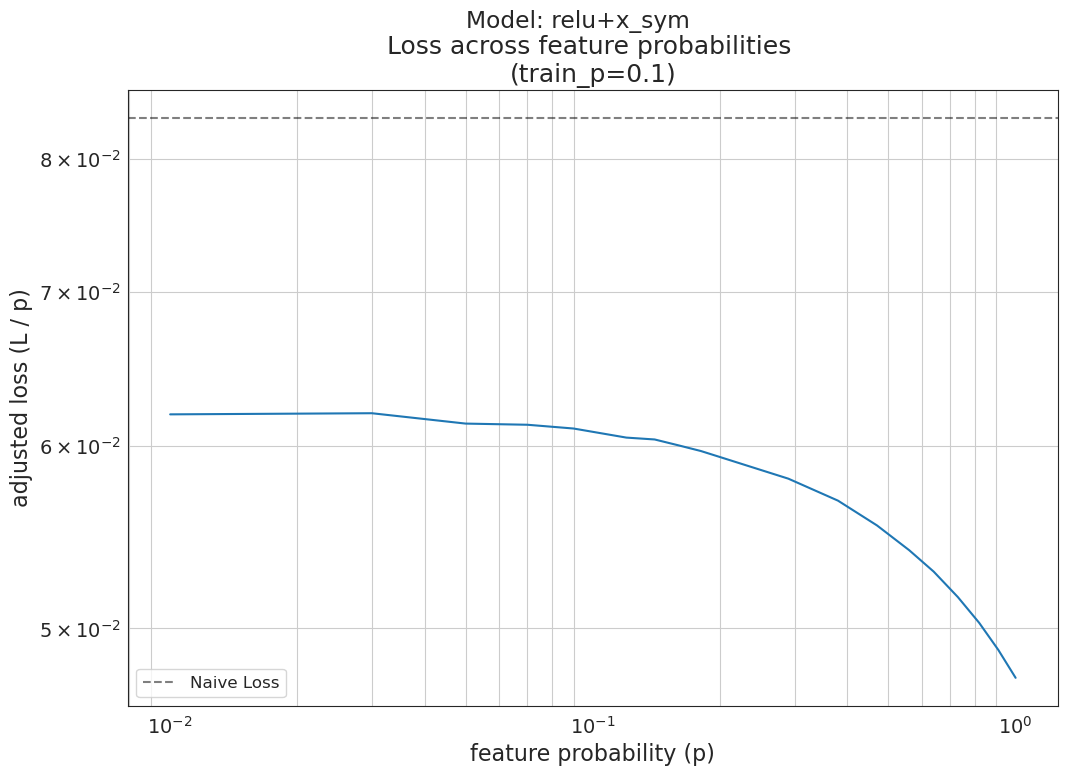

In [148]:
sparsity_low = np.round(np.linspace(0.0, 0.8, 10), 2)
sparsity_high = np.round(np.linspace(0.8, 0.99, 10), 2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))

for model, name, target in zip(models, model_names, targets, strict=True):
    ax, _ = plot.plot_loss_across_sparsities(
        sparsities=sparsities,
        model=model,
        eval_model=eval_model,
        target=target,
        train_sparsity=feat_sparsity,
    )
    ax.figure.suptitle(f"Model: {name}")
    ax.grid(which="both", axis="both")

# Input-output Quiver plots
Take a 2-features, 1-neuron model. Make a quiver plot of input and outputs + arrow of input transformation of model. Repeat for different noise matrices (symmetric, asymmetric, different levels of effective rank, no noise).

In [159]:
Wn = t.eye(model.cfg.n_feat, dtype=model.dtype, device=model.device).expand(
                model.cfg.n_instances, -1, -1
            )
Wn = Wn + cis_simple_sym.noise_coeff * cis_simple_sym.noise_base              

print(Wn)

tensor([[[ 1.0000, -0.3345],
         [-0.3345,  1.0000]]], device='cuda:0', grad_fn=<AddBackward0>)


torch.Size([9, 1, 2])
x.shape =  torch.Size([9, 1, 2])
Wn.shape =  torch.Size([1, 2, 2])
(9, 2)
(9, 2)
(9,)
(9,)


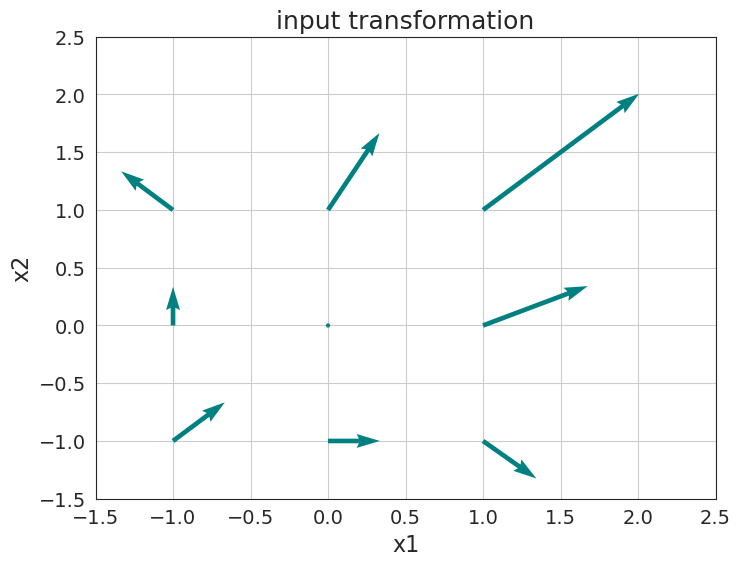

(9,)
(9,)


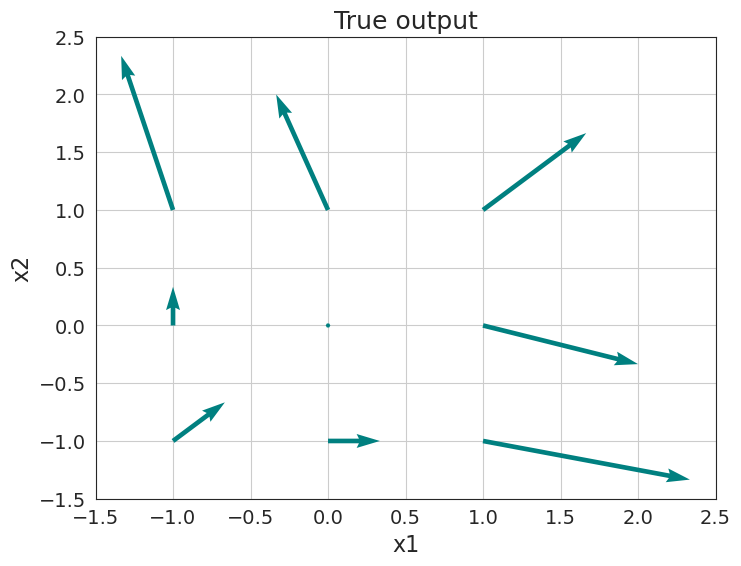

[[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
[[-0.66547865 -0.66547865]
 [-1.          0.33452135]
 [-1.3345213   1.3345213 ]
 [ 0.33452135 -1.        ]
 [ 0.          0.        ]
 [ 0.33147424  1.6656793 ]
 [ 1.3441486  -1.3248985 ]
 [ 1.6756229   0.3407808 ]
 [ 2.0070972   2.0064602 ]]


In [170]:
feat_sparsity = 0.9

#, relu_x = gen_batch(cis_simple_sym, 1024, feat_sparsity, device)

model = cis_simple_sym

import itertools

# Step 1: Define possible values
values = [-1, 0, 1]

# Step 2: Create meshgrid using Cartesian product
mesh_points = list(itertools.product(values, repeat=2))  # All (x, y) pairs

# Step 3: Convert to tensor
data = t.tensor(mesh_points, dtype=t.float32, device=device)  # shape: (9, 2)

# Step 4: Reshape to (n_examples, 1, n_features)
x = data.unsqueeze(1)  # shape: (9, 1, 2)

print(x.shape)  # torch.Size([9, 1, 2])

with t.no_grad():
    y_pred = model.forward(x)

y_true = t.relu(x)

Wn = t.eye(model.cfg.n_feat, dtype=model.dtype, device=model.device).expand(
                model.cfg.n_instances, -1, -1
            )
Wn = Wn + model.noise_coeff * model.noise_base    
print('x.shape = ', x.shape)
print('Wn.shape = ', Wn.shape)
import torch as t

# Input x: (25, 1, 2) → squeeze to remove the middle dim
x = x.squeeze(1)  # Shape: (25, 2)

# Expand Wn from (1, 2, 2) to match the batch size for broadcasting
Wn = Wn.expand(x.shape[0], -1, -1)  # Now Wn is (25, 2, 2)

# Reshape x for matmul: (25, 2) → (25, 2, 1)
x_unsqueezed = x.unsqueeze(-1)  # (25, 2, 1)

# Compute matrix multiplication: (25, 2, 2) @ (25, 2, 1) → (25, 2, 1)
Wn_x = t.matmul(Wn, x_unsqueezed).squeeze(-1)  # (25, 2)

# Final true output
y_true = t.relu(x) + Wn_x  # Shape: (25, 2)

x = x.squeeze(1).cpu().detach().numpy()
y_pred = y_pred.squeeze(1).cpu().detach().numpy()
y_true = y_true.cpu().detach().numpy()
#relu_x = relu_x.squeeze(1).cpu().detach().numpy()

print(x.shape)
print(y_pred.shape)


# Displacement vectors
U = y_pred[:,0] - x[:,0]
V = y_pred[:,1] - x[:,1]

print(U.shape)
print(V.shape)

plt.figure(figsize=(8, 6))
plt.quiver(x[:,0], x[:,1], U, V, angles='xy', scale_units='xy', scale=1, color='teal')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.title('input transformation')
plt.grid(True)
#plt.axis('equal')
plt.show()


# Displacement vectors
U = y_true[:,0] - x[:,0]
V = y_true[:,1] - x[:,1]

print(U.shape)
print(V.shape)

plt.figure(figsize=(8, 6))
plt.quiver(x[:,0], x[:,1], U, V, angles='xy', scale_units='xy', scale=1, color='teal')
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('True output')
plt.grid(True)
#plt.axis('equal')
plt.show()

print(x)
print(y_pred)

t.relu(x).shape =  torch.Size([25, 2])
Wn_x.shape =  torch.Size([25, 2])


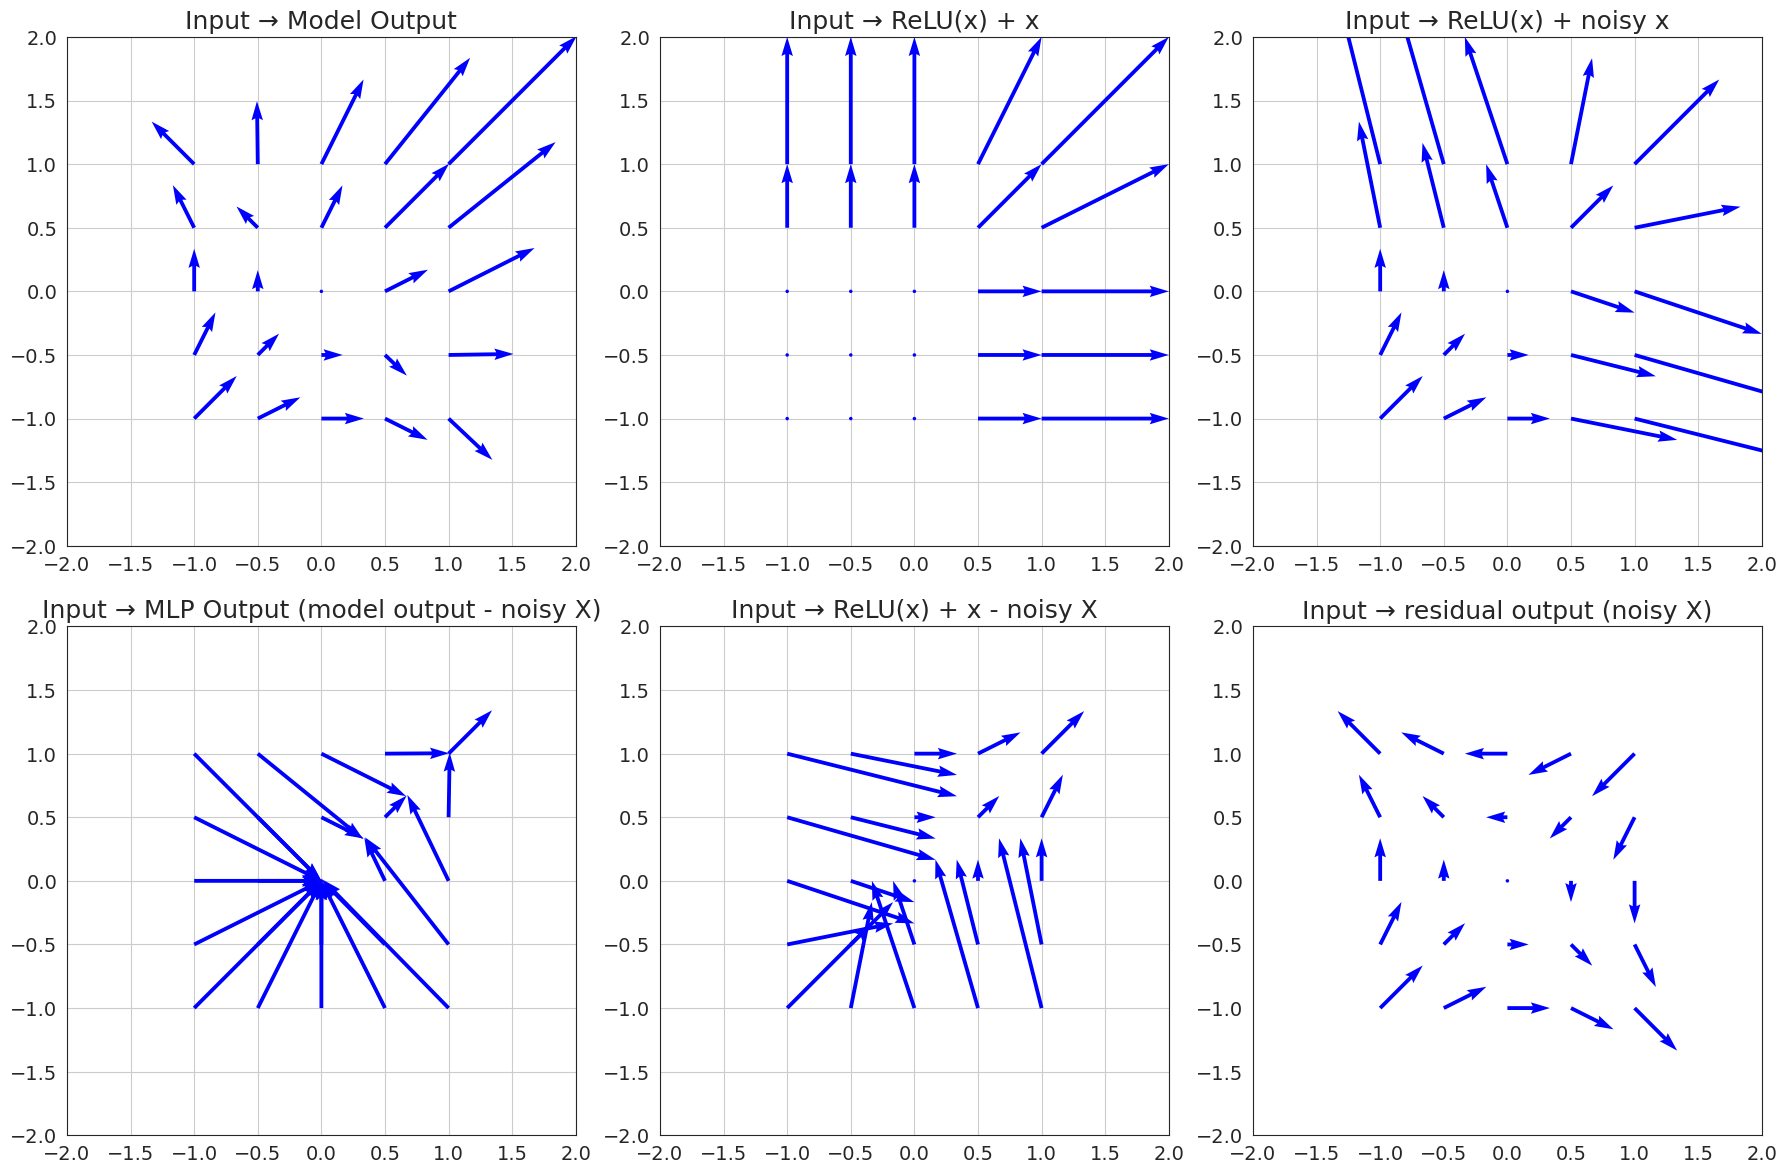

In [195]:
"""Quiver plots of input to outputs for ReLu + noise model"""
import itertools

# Generate the input data points
feat_sparsity = 0.9
model = cis_simple_sym
values = [-1,-0.5, 0, 0.5, 1]
mesh_points = list(itertools.product(values, repeat=2))  # All (x, y) pairs
data = t.tensor(mesh_points, dtype=t.float32, device=device)  # shape: (9, 2)
x = data.unsqueeze(1)  # shape: (9, 1, 2)

# Compute model output
with t.no_grad():
    y_pred = model.forward(x)

# Compute training target
y_training = t.relu(x) + x

# Compute output ReLU(x) + noisyX
Wn = t.eye(model.cfg.n_feat, dtype=model.dtype, device=model.device).expand(
                model.cfg.n_instances, -1, -1
            )
Wn = Wn + model.noise_coeff * model.noise_base    
x = x.squeeze(1)  # Shape: (25, 2)
Wn = Wn.expand(x.shape[0], -1, -1)  # Now Wn is (25, 2, 2)
x_unsqueezed = x.unsqueeze(-1)  # (25, 2, 1)
Wn_x = t.matmul(Wn, x_unsqueezed).squeeze(-1)  # (25, 2)
y_true = t.relu(x) + Wn_x  # Shape: (25, 2)

# Compute true ReLU(x) - noisyX
print('t.relu(x).shape = ', t.relu(x).shape)
print('Wn_x.shape = ', Wn_x.shape)
true_MLP = t.relu(x) + x - Wn_x

# Compute pure MLP output 
MLP_output = y_pred.squeeze(1) - Wn_x

# Compute residual output 
res_output = Wn_x

# convert tensors to numpy for plotting
x = x.squeeze(1).cpu().detach().numpy()
y_pred = y_pred.squeeze(1).cpu().detach().numpy()
y_training = y_training.squeeze(1).cpu().detach().numpy()
y_true = y_true.squeeze(1).cpu().detach().numpy()
true_MLP = true_MLP.squeeze(1).cpu().detach().numpy()
MLP_output = MLP_output.squeeze(1).cpu().detach().numpy()
res_output = res_output.cpu().detach().numpy()

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Helper function to make a quiver plot
def make_quiver(ax, x, out, title):
    U = out[:,0] - x[:,0]
    V = out[:,1] - x[:,1]
    ax.quiver(x[:, 0], x[:, 1], U, V, angles='xy', scale_units='xy', scale=1, color='blue')
    ax.set_title(title)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid()

# Plot 1: Input to model output
make_quiver(axes[0], x, y_pred, "Input → Model Output")

# Plot 2: Input to training target
make_quiver(axes[1], x, y_training, "Input → ReLU(x) + x")

# Plot 3: Input to true output (ReLU + Wn x)
make_quiver(axes[2], x, y_true, "Input → ReLU(x) + noisy x")

# Plot 4: Input to MLP output
make_quiver(axes[3], x, MLP_output, "Input → MLP Output (model output - noisy X)")

# Plot 5: Input to ReLU(x) - noisy x
make_quiver(axes[4], x, true_MLP, "Input → ReLU(x) + x - noisy X")

# Plot 6: Input to residual output
make_quiver(axes[5], x, res_output, "Input → residual output (noisy X)")

plt.tight_layout()
plt.savefig('/workspace/reluPlusX_sym_noise_quiver.png', dpi=300)
plt.show()

(9,)
(9,)


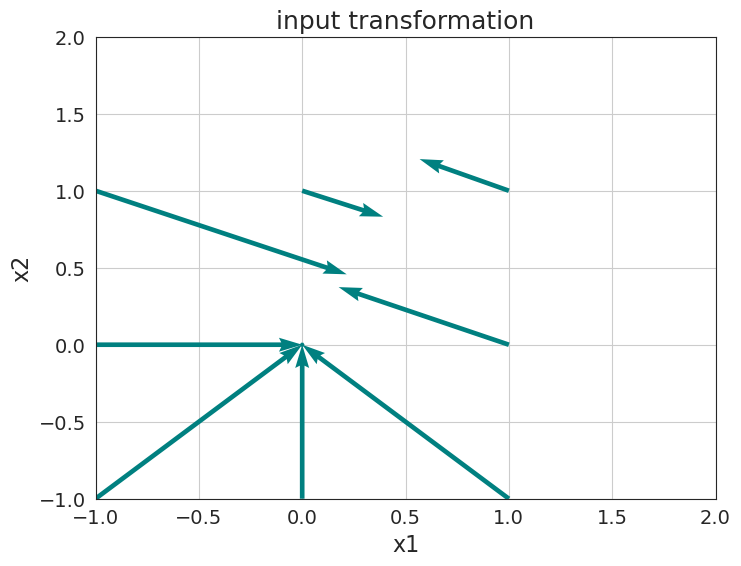

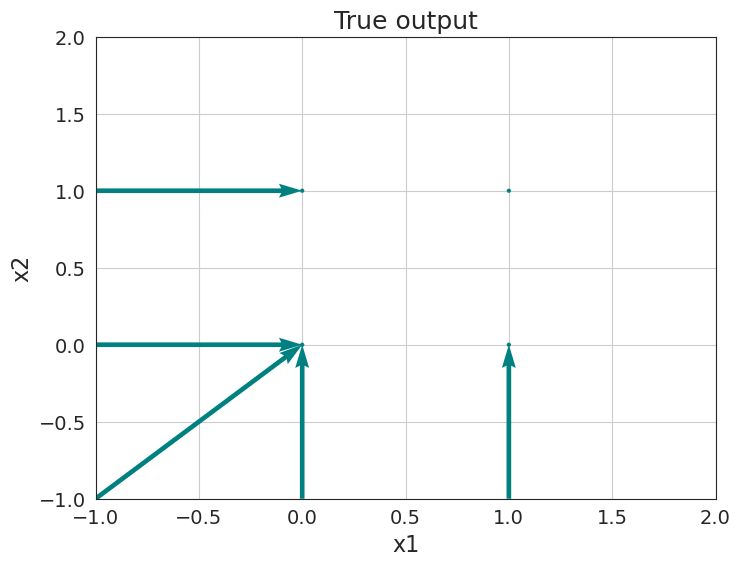

In [176]:
feat_sparsity = 0.9

#, relu_x = gen_batch(cis_simple_sym, 1024, feat_sparsity, device)

model = cis_simple

import itertools

# Step 1: Define possible values
values = [-1, 0, 1]

# Step 2: Create meshgrid using Cartesian product
mesh_points = list(itertools.product(values, repeat=2))  # All (x, y) pairs

# Step 3: Convert to tensor
data = t.tensor(mesh_points, dtype=t.float32, device=device)  # shape: (9, 2)

# Step 4: Reshape to (n_examples, 1, n_features)
x = data.unsqueeze(1)  # shape: (9, 1, 2)

with t.no_grad():
    y_pred = model.forward(x)

y_true = t.relu(x)

x = x.squeeze(1).cpu().detach().numpy()
y_pred = y_pred.squeeze(1).cpu().detach().numpy()
y_true = y_true.squeeze(1).cpu().detach().numpy()

# Displacement vectors
U = y_pred[:,0] - x[:,0]
V = y_pred[:,1] - x[:,1]

print(U.shape)
print(V.shape)

plt.figure(figsize=(8, 6))
plt.quiver(x[:,0], x[:,1], U, V, angles='xy', scale_units='xy', scale=1, color='teal')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1,2)
plt.ylim(-1,2)
plt.title('input transformation')
plt.grid(True)
#plt.axis('equal')
plt.show()


# Displacement vectors
U = y_true[:,0] - x[:,0]
V = y_true[:,1] - x[:,1]

plt.figure(figsize=(8, 6))
plt.quiver(x[:,0], x[:,1], U, V, angles='xy', scale_units='xy', scale=1, color='teal')
plt.xlim(-1,2)
plt.ylim(-1,2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('True output')
plt.grid(True)
#plt.axis('equal')
plt.show()